In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import scipy.stats as stats
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Data Inspection

In [3]:
medical_raw = pd.read_csv('data/medical_raw_data.csv')
medical_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          10000 non-null  int64  
 1   CaseOrder           10000 non-null  int64  
 2   Customer_id         10000 non-null  object 
 3   Interaction         10000 non-null  object 
 4   UID                 10000 non-null  object 
 5   City                10000 non-null  object 
 6   State               10000 non-null  object 
 7   County              10000 non-null  object 
 8   Zip                 10000 non-null  int64  
 9   Lat                 10000 non-null  float64
 10  Lng                 10000 non-null  float64
 11  Population          10000 non-null  int64  
 12  Area                10000 non-null  object 
 13  Timezone            10000 non-null  object 
 14  Job                 10000 non-null  object 
 15  Children            7412 non-null   float64
 16  Age  

In [4]:
medical_raw.head()

,Unnamed: 0,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,...,3191.048774,17939.403420,3,3,2,2,4,3,3,4
1,2,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,...,4214.905346,17612.998120,3,4,3,4,4,4,3,3
2,3,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,...,2177.586768,17505.192460,2,4,4,4,3,4,3,3
3,4,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,...,2465.118965,12993.437350,3,5,5,3,4,5,5,5
4,5,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,...,1885.655137,3716.525786,2,1,3,3,5,3,4,3


# Fixing Inconsistencies

## Column names

The first thing we notice is the columns of the dataset follow the naming convention of using underscores between words... except for TotalCharge, HighBlood, and BackPain which simply capitalizes the second word. We'll fix this inconsistency before we move forward.

In [5]:
medical_raw.rename(columns = {'TotalCharge': 'Total_charge'}, inplace=True)
medical_raw.rename(columns = {'HighBlood': 'High_blood'}, inplace=True)
medical_raw.rename(columns = {'BackPain': 'Back_pain'}, inplace=True)

## Boolean features

We have a few columns that have either "yes" and "no", or "1" and "0", values. We'll standardize all of them to be "1" for yes and "0" for no. We do this for consistency and because it is easier to perform analysis on numerical data.

In [6]:
medical_raw['ReAdmis'] = medical_raw['ReAdmis'].replace({"Yes": 1, "No": 0})
medical_raw['Soft_drink'] = medical_raw['Soft_drink'].replace({"Yes": 1, "No": 0})
medical_raw['High_blood'] = medical_raw['High_blood'].replace({"Yes": 1, "No": 0})
medical_raw['Stroke'] = medical_raw['Stroke'].replace({"Yes": 1, "No": 0})
medical_raw['Arthritis'] = medical_raw['Arthritis'].replace({"Yes": 1, "No": 0})
medical_raw['Diabetes'] = medical_raw['Diabetes'].replace({"Yes": 1, "No": 0})
medical_raw['Hyperlipidemia'] = medical_raw['Hyperlipidemia'].replace({"Yes": 1, "No": 0})
medical_raw['Back_pain'] = medical_raw['Back_pain'].replace({"Yes": 1, "No": 0})
medical_raw['Allergic_rhinitis'] = medical_raw['Allergic_rhinitis'].replace({"Yes": 1, "No": 0})
medical_raw['Reflux_esophagitis'] = medical_raw['Reflux_esophagitis'].replace({"Yes": 1, "No": 0})
medical_raw['Asthma'] = medical_raw['Asthma'].replace({"Yes": 1, "No": 0})

# Handling Null Values

Let's check which columns contain null values:

In [7]:
medical_raw.isnull().any()

Unnamed: 0            False
CaseOrder             False
Customer_id           False
Interaction           False
UID                   False
City                  False
State                 False
County                False
Zip                   False
Lat                   False
Lng                   False
Population            False
Area                  False
Timezone              False
Job                   False
Children               True
Age                    True
Education             False
Employment            False
Income                 True
Marital               False
Gender                False
ReAdmis               False
VitD_levels           False
Doc_visits            False
Full_meals_eaten      False
VitD_supp             False
Soft_drink             True
Initial_admin         False
High_blood            False
Stroke                False
Complication_risk     False
Overweight             True
Arthritis             False
Diabetes              False
Hyperlipidemia      

Upon inspection we find that the following columns contain null values:
    
- Children
- Age
- Income
- soft_drink
- Overweight
- Anxiety
- Initial_days

## Children
For the Children column, we will use ``fillna()`` from pandas specifying ``method='bfill'`` to fill in the missing data based on the data that is not null. 

In [8]:
medical_raw['Children'].fillna(method='bfill', inplace=True)

Check if there are any null values remaining:

In [9]:
medical_raw['Children'].isna().sum()

0

## Age

In [10]:
medical_raw['Age'].isna().sum()


2414

We'll use the same methodology for Age that we used for Children previously.

In [11]:
medical_raw['Age'].fillna(round(medical_raw['Age'].mean()), inplace=True)

Check if there are any null values remaining:

In [12]:
medical_raw['Age'].isna().sum()

0

## Income

In [13]:
medical_raw['Income'].isna().sum()

2464

For Income we will replace the null values with the mean of the given values.

In [14]:
income_mean = medical_raw['Income'].mean()
income_mean

40484.43826831216

In [15]:
medical_raw['Income'].fillna(medical_raw['Income'].mean(), inplace=True)

In [16]:
medical_raw['Income'].isna().sum()

0

## Soft_drink

In [17]:
medical_raw['Soft_drink'].isna().sum()

2467

Since soft_drink is categorical, either a "Yes" or "No", we'll replace the nulls with the mode.

In [18]:
medical_raw['Soft_drink'].fillna(medical_raw['Soft_drink'].mode()[0], inplace=True)
medical_raw['Soft_drink'].isnull().sum()

0

## Overweight

In [19]:
medical_raw['Overweight'].isna().sum()

982

Overweight is also categorical, though it is "0" and "1" instead of "yes and "no" (we'll fix these inconsitencies in the categorical values later). We'll use the same method we used for soft_drink.

In [20]:
medical_raw['Overweight'].fillna(medical_raw['Overweight'].mode()[0], inplace=True)
medical_raw['Overweight'].isna().sum()

0

## Anxiety
Another categorical! we use mode again

In [21]:
medical_raw['Anxiety'].isna().sum()

984

In [22]:
medical_raw['Anxiety'].fillna(medical_raw['Anxiety'].mode()[0], inplace=True)
medical_raw['Anxiety'].isna().sum()

0

## Initial_days
Numerical

In [23]:
medical_raw['Initial_days'].isna().sum()

1056

In [24]:
medical_raw['Initial_days'].fillna(medical_raw['Initial_days'].mean(), inplace=True)
medical_raw['Initial_days'].isna().sum()

0

In [25]:
medical_raw.isnull().any()

Unnamed: 0            False
CaseOrder             False
Customer_id           False
Interaction           False
UID                   False
City                  False
State                 False
County                False
Zip                   False
Lat                   False
Lng                   False
Population            False
Area                  False
Timezone              False
Job                   False
Children              False
Age                   False
Education             False
Employment            False
Income                False
Marital               False
Gender                False
ReAdmis               False
VitD_levels           False
Doc_visits            False
Full_meals_eaten      False
VitD_supp             False
Soft_drink            False
Initial_admin         False
High_blood            False
Stroke                False
Complication_risk     False
Overweight            False
Arthritis             False
Diabetes              False
Hyperlipidemia      

In [26]:
medical_raw.to_csv('data/clean.csv')

# Handling Outliers

Now we'll check all of the numeric data fields for outliers and handle them if needed.

In [27]:
%matplotlib inline

## Z-scores
We're going to add a column to the dataset for each numeric feature that contains a standardized z-score. We'll leave the original columns unaltered so the original data are still accessible. 

In [28]:
medical_raw['Zscore_Population'] = stats.zscore(medical_raw['Population'])
medical_raw['Zscore_Children'] = stats.zscore(medical_raw['Children'])
medical_raw['Zscore_Age'] = stats.zscore(medical_raw['Age'])
medical_raw['Zscore_Income'] = stats.zscore(medical_raw['Income'])
medical_raw['Zscore_Doc_visits'] = stats.zscore(medical_raw['Doc_visits'])
medical_raw['Zscore_Full_meals_eaten'] = stats.zscore(medical_raw['Full_meals_eaten'])
medical_raw['Zscore_Initial_days'] = stats.zscore(medical_raw['Initial_days'])
medical_raw['Zscore_Total_charge'] = stats.zscore(medical_raw['Total_charge'])
medical_raw['Zscore_Additional_charges'] = stats.zscore(medical_raw['Additional_charges'])

<AxesSubplot:>

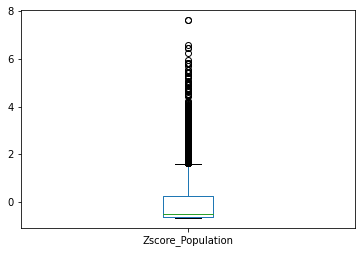

In [29]:
medical_raw['Zscore_Population'].plot.box()

<AxesSubplot:>

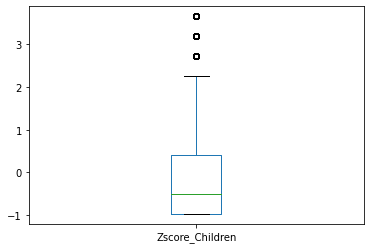

In [30]:
medical_raw['Zscore_Children'].plot.box()

<AxesSubplot:>

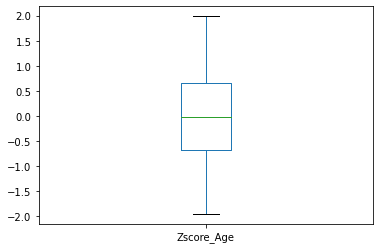

In [31]:
medical_raw['Zscore_Age'].plot.box()

<AxesSubplot:>

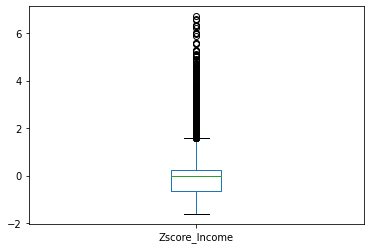

In [32]:
medical_raw['Zscore_Income'].plot.box()

<AxesSubplot:>

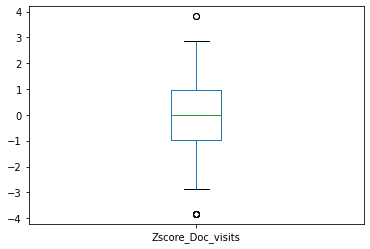

In [33]:
medical_raw['Zscore_Doc_visits'].plot.box()

<AxesSubplot:>

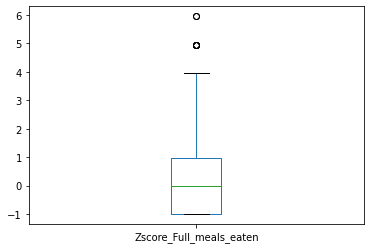

In [34]:
medical_raw['Zscore_Full_meals_eaten'].plot.box()

<AxesSubplot:>

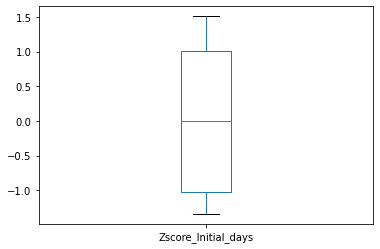

In [35]:
medical_raw['Zscore_Initial_days'].plot.box()

<AxesSubplot:>

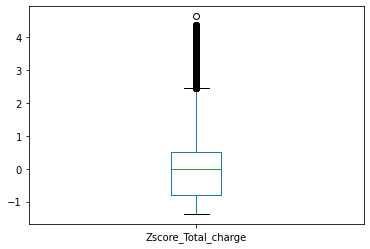

In [36]:
medical_raw['Zscore_Total_charge'].plot.box()

<AxesSubplot:>

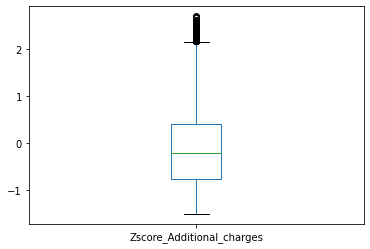

In [37]:
medical_raw['Zscore_Additional_charges'].plot.box()

# Principle Component Analysis

In [38]:
# adapted from "Data Science Foundations: Data Mining" chapter 2 section 4
X = medical_raw[['Soft_drink', 'High_blood', 'Stroke', 'Overweight', 'Diabetes', 
                 'Hyperlipidemia', 'Back_pain', 'Anxiety', 'Allergic_rhinitis', 
                 'Reflux_esophagitis', 'Asthma', 'Item1', 'Item2', 'Item3', 'Item4', 
                 'Item5', 'Item6', 'Item7', 'Item8', 'Zscore_Population', 'Zscore_Children', 'Zscore_Age', 
                 'Zscore_Income', 'Zscore_Doc_visits', 'Zscore_Full_meals_eaten', 
                 'Zscore_Initial_days', 'Zscore_Total_charge', 'Zscore_Additional_charges']]

In [39]:
medical_normalized = (X-X.mean())/X.std()

In [40]:
pca = PCA(n_components=X.shape[1])
pca.fit(medical_normalized)
print(pca.explained_variance_ratio_)

[0.10555983 0.06833995 0.05935117 0.05710467 0.03829965 0.03756669
 0.03731658 0.03697541 0.03671249 0.03633056 0.03624293 0.03575263
 0.0356934  0.03551563 0.03504496 0.0347462  0.03439649 0.03378646
 0.03362811 0.03326423 0.02738554 0.02483262 0.02097662 0.01901213
 0.0168527  0.01409839 0.01165711 0.00355685]


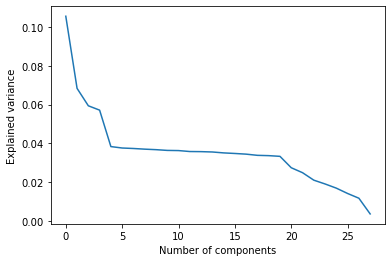

In [41]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [42]:
cov_matrix = np.dot(medical_normalized.T, medical_normalized / medical_normalized.shape[0])
eigenvalues = [np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]

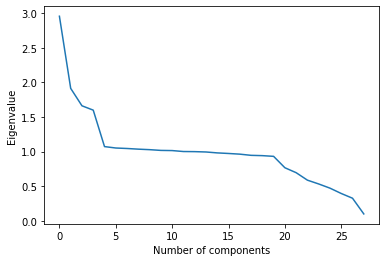

In [43]:
plt.plot(eigenvalues)
plt.xlabel('Number of components')
plt.ylabel('Eigenvalue')
plt.show()

In [45]:
loadings = pd.DataFrame(pca.components_.T, index=medical_normalized.columns)
loadings

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Soft_drink,0.006699,0.001290,-0.011021,0.009945,0.270668,0.188216,0.493427,-0.227849,-0.176596,-0.203660,...,-0.172550,-0.002912,-0.042917,-0.042161,-0.019622,-0.022970,0.009466,0.005958,-0.016062,0.002343
High_blood,-0.004275,0.509045,-0.034166,-0.045650,-0.180190,0.130361,-0.068763,0.169801,0.209909,-0.262584,...,-0.298921,-0.090384,-0.019798,-0.025505,-0.010136,0.013138,-0.013337,-0.027163,0.006032,0.511612
Stroke,-0.002684,0.037366,-0.022919,-0.008746,0.031067,0.058381,-0.079772,0.066066,-0.124495,0.653645,...,0.144420,-0.112637,-0.027671,-0.005642,-0.024555,0.007986,0.010987,0.014578,0.008417,0.015599
Overweight,0.004241,0.018845,-0.027435,-0.030096,-0.421873,-0.305640,0.193228,0.097652,0.170671,-0.148307,...,0.444712,0.196071,-0.041495,0.024872,-0.004228,-0.007004,-0.008543,0.003466,-0.001368,0.000150
Diabetes,-0.003022,0.000677,-0.034888,0.004111,0.362358,-0.050037,0.116749,0.100768,-0.247399,-0.083707,...,0.040097,0.341799,0.035117,-0.001668,-0.002667,-0.028021,-0.018109,0.000795,0.013587,0.001756
Hyperlipidemia,0.017060,-0.007281,0.021983,0.010946,0.231650,-0.121694,-0.162311,-0.524752,0.035941,-0.432353,...,0.222778,-0.323103,0.063292,-0.006865,0.004721,-0.004341,0.024850,-0.017799,0.013231,0.003352
Back_pain,-0.013097,0.023855,0.024818,0.037077,-0.197766,0.092560,0.514419,-0.414553,0.030069,0.212443,...,-0.256034,0.260984,0.008172,0.044140,0.024376,-0.021564,-0.010646,-0.007065,-0.001078,0.000886
Anxiety,-0.000489,0.019434,0.035069,0.017759,0.238258,0.049465,0.263240,0.182107,0.254281,0.035079,...,0.419349,-0.002590,-0.051121,0.001980,0.000120,0.011548,0.005744,-0.027509,-0.002240,0.000693
Allergic_rhinitis,0.004833,0.027466,-0.008355,0.026639,-0.063451,-0.185367,0.256701,0.303837,0.033113,-0.140267,...,-0.129891,-0.134105,-0.017863,-0.011900,0.027574,0.016210,-0.027880,-0.002950,0.001274,-0.001041
Reflux_esophagitis,0.006451,-0.014118,0.025992,0.030077,-0.027030,0.459389,-0.085168,-0.260432,0.292560,0.054314,...,0.291397,-0.144921,0.056417,0.061127,-0.020089,-0.012793,-0.031099,-0.002359,0.003082,-0.002080
